In [21]:
# https://zh.d2l.ai/chapter_recurrent-neural-networks/sequence.html
from matplotlib import pyplot as plt

In [1]:
%matplotlib inline
import tensorflow as tf
#


2022-05-01 15:07:35.016211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 15:07:35.016253: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from d2l import tensorflow as d2l

2022-05-01 15:11:05.578416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 15:11:05.578464: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 15:11:05.578516: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-KH2BV74): /proc/driver/nvidia/version does not exist
2022-05-01 15:11:05.579287: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


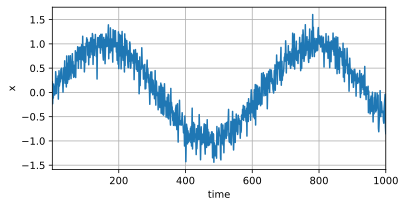

In [3]:
T = 1000  # 总共产生1000个点
time = tf.range(1, T + 1, dtype=tf.float32)
x = tf.sin(0.01 * time) + tf.random.normal([T], 0, 0.2)
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))


In [4]:
tau = 4
features = tf.Variable(tf.zeros((T - tau, tau)))
for i in range(tau):
    features[:, i].assign(x[i: T - tau + i])
labels = tf.reshape(x[tau:], (-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array(
    (features[:n_train], labels[:n_train]),
    batch_size, is_train=True,
)

In [18]:
def get_net():
    net = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1),
    ])
    return net

# 最小均方损失。注意：MeanSquaredError计算平方误差时不带系数1/2
loss = tf.keras.losses.MeanSquaredError()
def train(net, train_iter, loss, epochs, lr):
    trainer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        for X, y in train_iter:
            with tf.GradientTape() as g:
                out = net(X)
                l = loss(y, out)
                params = net.trainable_variables
                grads = g.gradient(l, params)
            trainer.apply_gradients(zip(grads, params))
        print(f'epoch {epoch + 1}, loss: {d2l.evaluate_loss(net, train_iter, loss):f}')


In [19]:
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.649561
epoch 2, loss: 0.409310
epoch 3, loss: 0.236602
epoch 4, loss: 0.137465
epoch 5, loss: 0.092809


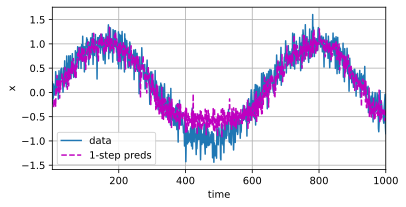

In [20]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.numpy(), onestep_preds.numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))


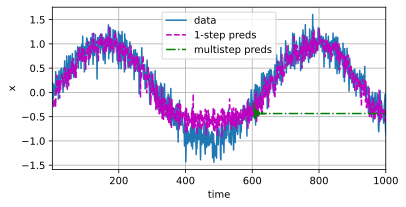

In [22]:
multistep_preds = tf.Variable(tf.zeros(T))
multistep_preds[:n_train + tau].assign(x[:n_train + tau])
for i in range(n_train + tau, T):
    multistep_preds[i].assign(tf.reshape(net(
        tf.reshape(multistep_preds[i - tau: i], (1, -1))), ()))

d2l.plot(
    [
        time,
        time[tau:],
        time[n_train + tau:],
    ],
    [x.numpy(), onestep_preds.numpy(), multistep_preds[n_train + tau:].numpy()], 
    'time',
    'x', 
    legend=['data', '1-step preds', 'multistep preds'],
    xlim=[1, 1000], figsize=(6, 3))
